In [4]:
import hyperiax
from jax.random import PRNGKey, split
import jax
from jax import numpy as jnp
from jax import vmap, lax

key = PRNGKey(0)

In [5]:
import pandas as pd
import numpy as np
import requests 

from hyperiax.tree.topology import read_topology
from hyperiax.tree import HypTree
# Load all files

# Phylogenic tree
tree_string = requests.get("https://raw.githubusercontent.com/MichaelSev/Hyperiax_data/main/tree.txt").text
tree = read_topology(tree_string)
landmark = pd.read_csv("https://raw.githubusercontent.com/MichaelSev/Hyperiax_data/main/landmarks.csv", sep=",", header=None)

((Graphium_evemon:0.06883,Graphium_sarpedon:0.06835)QS1810:0.13941,(Atrophaneura_dixoni:0.0434,Pachliopta_aristolochiae:0.05484)QS1845:0.16755)QS1804:0;



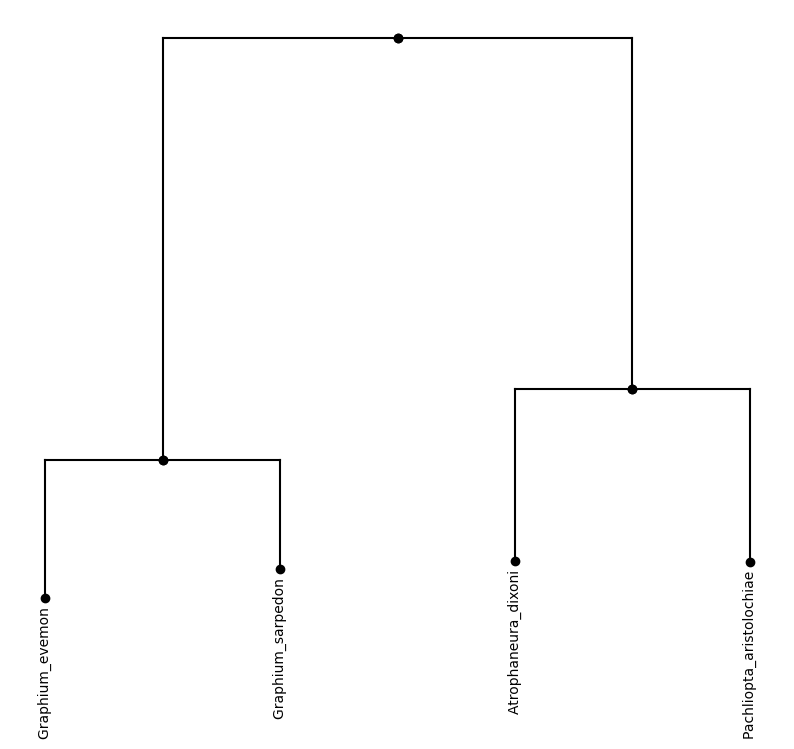

In [ ]:
from hyperiax.plotting import plot_tree

# Plot the tree
plot_tree(tree,inc_names=True)
print(tree_string)

In [7]:
# The name of the landmarks are placed in the tree, alongside with the edgelength 
l_dim = (jnp.shape(landmark)[1])
tree.add_property('value', shape=(int(jnp.shape(landmark)[1]),))
# add landmarks
landmark_array = landmark.to_numpy()
reshaped_array = landmark_array.reshape(landmark_array.shape[0], landmark_array.shape[1])
tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(reshaped_array)

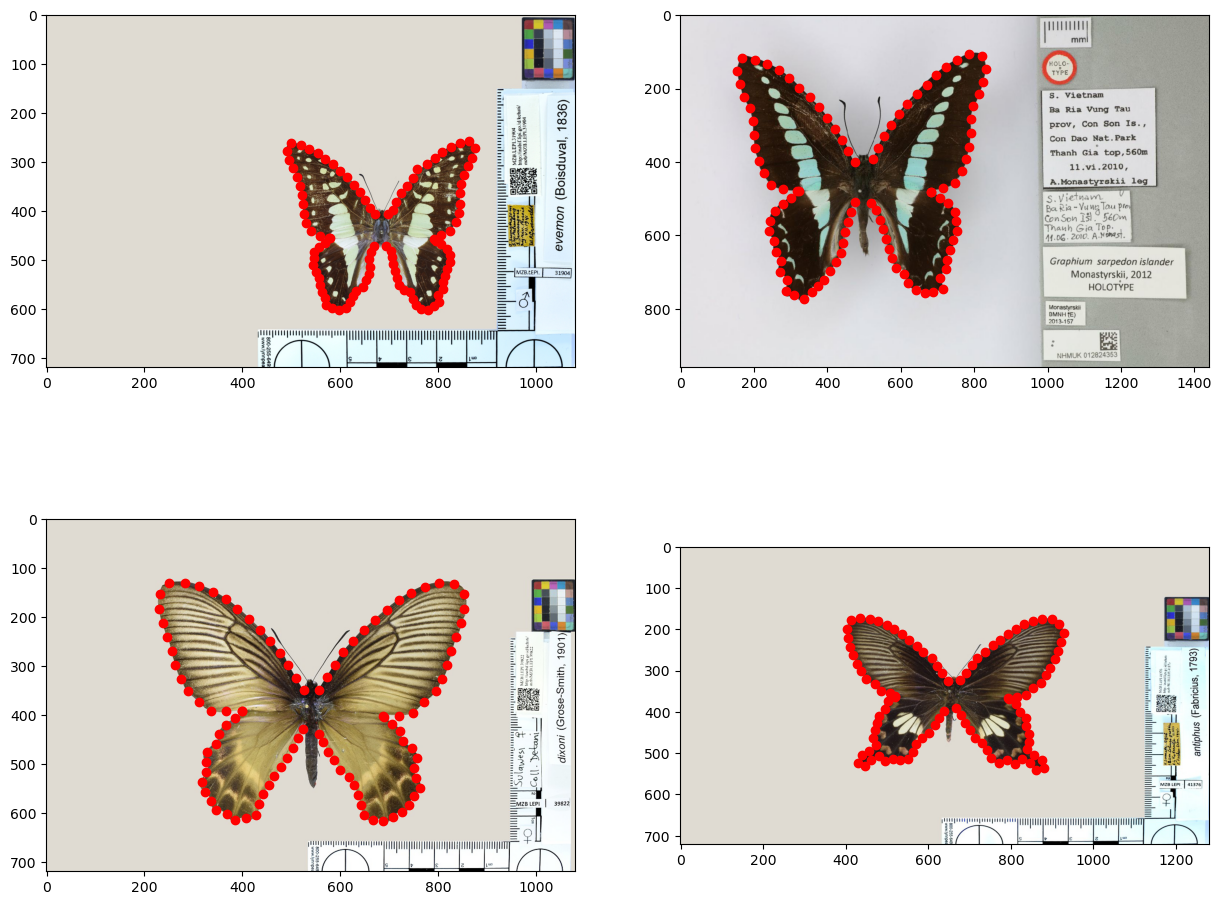

In [15]:
# Example of landmarks 
import matplotlib.pyplot as plt
from PIL import Image

main_path = "https://github.com/MichaelSev/Hyperiax_data/raw/main/image/"

list_of_names =["img0.jpg","img1.jpg","img2.jpg","img3.jpg"]
for i,data in enumerate(tree.data['value'][tree.is_leaf]):
    plt.subplot(2,2,i+1)
    im = Image.open(requests.get(main_path+list_of_names[i], stream=True).raw)
    implot = plt.imshow(im)
    plt.scatter(data[::2],data[1::2],c="r")
    #plt.title(str(leaf.name))

In [9]:
from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda
from hyperiax.models.functional import pass_up
from hyperiax.plotting import plot_tree_text, plot_tree_2d_scatter

from matplotlib import pyplot as plt

from functools import partial

# Requires Jaxdifferentalgeometry package
from jaxgeometry.manifolds.landmarks import *   
from jaxgeometry.Riemannian import metric
from jaxgeometry.dynamics import Hamiltonian
from jaxgeometry.Riemannian import Log
from jaxgeometry.dynamics import flow_differential

In [ ]:
# reload tree with precomputed children
toplogy  = read_topology(tree_string,return_topology=True)
pre_tree = HypTree(toplogy, precompute_child_gathers=True)
pre_tree.data = tree.data.copy()

In [11]:
# fix the space we expect to use for each parameter

# Saved parameters within the tree 
pre_tree.add_property('sigma', shape=(1,))

# Fixed sigma for simplification
pre_tree.data['sigma'] =  pre_tree.data['sigma'].at[:].set(0.5)

In [12]:
# function to compute ancestral species

def fuse_diff_IC(value,child_value, child_sigma, child_edge_length,leaf_mask,**kwargs):
  
    def diff_IC(child_coords1, child_coords2, kernel_sigma, parent_index):
      
        # Estimate the average distance between each landmark,
        # predefined kernel size
       
        M = landmarks(jnp.shape(child_coords1)[0]//2, k_sigma=jnp.array(kernel_sigma) * jnp.eye(2),m=2)
        # Riemannian structure
    
        metric.initialize(M)
        q = M.coords(jnp.array(child_coords1))
        v = (jnp.array(child_coords2), [0])
      
        Hamiltonian.initialize(M)
        # Logarithm map
        Log.initialize(M, f=M.Exp_Hamiltonian)
   

        # Estimate momentum
        p = M.Log(q, v)[0]
   
        # Hamiltonian
        (_, qps, charts_qp) = M.Hamiltonian_dynamics(q, p, dts(n_steps=100))
 
        # Return landmarks, contrast and phi
        return qps[parent_index, 0, :]

    # Map function, to determine the shortest branch from child to parent
    def map_function(child_coords_pair, child_edge_length_pair, kernel_sigma_pair):
        edge_length_sum = child_edge_length_pair.sum()
 
        def true_fun(_):
            parent_index = jnp.floor(child_edge_length_pair[0] / edge_length_sum * 100 - 1).astype(int)[0]
            return diff_IC(child_coords_pair[0, :], child_coords_pair[1, :], kernel_sigma_pair[:, 0], parent_index)

        def false_fun(_):
            parent_index = jnp.floor(child_edge_length_pair[1] / edge_length_sum * 100 - 1).astype(int)[0]
            return diff_IC(child_coords_pair[1, :], child_coords_pair[0, :], kernel_sigma_pair[:, 0], parent_index)

        # Run Upwards LDDMM; from either left or right

        return jax.lax.cond((child_edge_length_pair[0] < child_edge_length_pair[1])[0], true_fun, false_fun, operand=None)

    # vmap to iterate over set of children
    qps = jax.vmap(map_function, in_axes=(0, 0, 0))(child_value, child_edge_length, child_sigma)
    qps = jnp.where(leaf_mask[:,None], value, qps)


    return {'value': qps}

#### Now we use UpLambda() to wrap the fuse function and throw it to OrderedExecutor, then simply just #### call .up().

In [13]:
upmodel = UpLambda(up_fn=fuse_diff_IC)
upmodelexe = OrderedExecutor(upmodel)
res = upmodelexe.up(pre_tree)

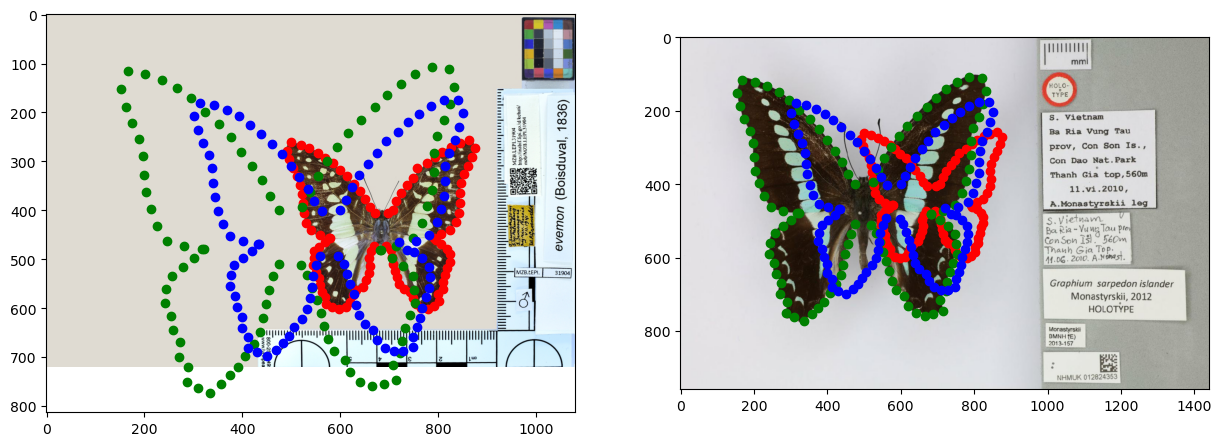

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

# Illustrate the results
plt.subplot(1, 2, 1)
# Load image 
im = Image.open(requests.get(main_path + "img0.jpg", stream=True).raw)
implot = plt.imshow(im)

# Plot points
plt.scatter(pre_tree.data['value'][3][::2], pre_tree.data['value'][3][1::2], color='red')    # child1 of root
plt.scatter(pre_tree.data['value'][4][::2], pre_tree.data['value'][4][1::2], color='green')  # child2 of root

plt.scatter(pre_tree.data['value'][1][::2], pre_tree.data['value'][1][1::2], color='blue')   # root


plt.subplot(1, 2, 2)
# Load image
im = Image.open(requests.get(main_path + "img1.jpg", stream=True).raw)
implot = plt.imshow(im)

# Plot points
plt.scatter(pre_tree.data['value'][3][::2], pre_tree.data['value'][3][1::2], color='red')    # child1 of root
plt.scatter(pre_tree.data['value'][4][::2], pre_tree.data['value'][4][1::2], color='green')  # child2 of root

plt.scatter(pre_tree.data['value'][1][::2], pre_tree.data['value'][1][1::2], color='blue')   # root


plt.show()

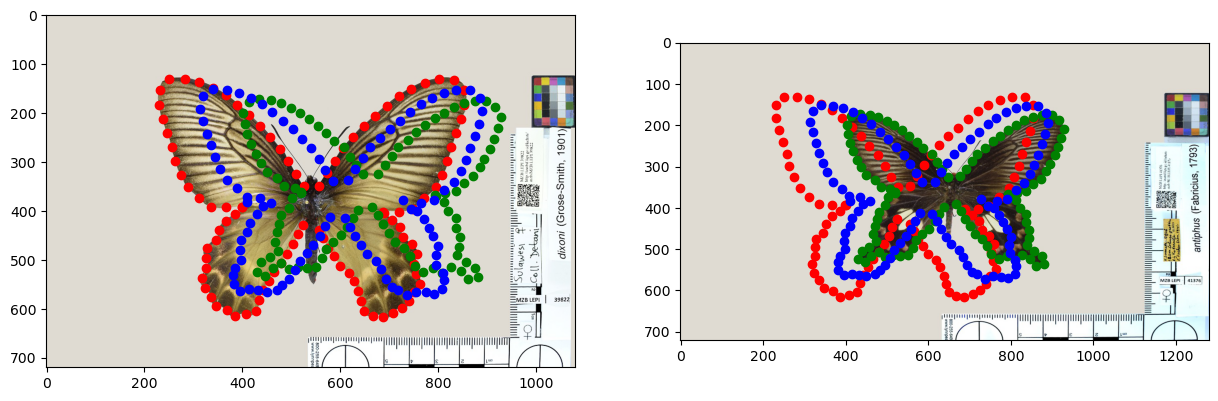

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

# Illustrate the results
plt.subplot(1, 2, 1)
# Load image 
im = Image.open(requests.get(main_path + "img2.jpg", stream=True).raw)
implot = plt.imshow(im)

# Plot points
plt.scatter(pre_tree.data['value'][5][::2], pre_tree.data['value'][5][1::2], color='red')    # child1 of root
plt.scatter(pre_tree.data['value'][6][::2], pre_tree.data['value'][6][1::2], color='green')  # child2 of root

plt.scatter(pre_tree.data['value'][2][::2], pre_tree.data['value'][2][1::2], color='blue')   # root


plt.subplot(1, 2, 2)
# Load image
im = Image.open(requests.get(main_path + "img3.jpg", stream=True).raw)
implot = plt.imshow(im)

# Plot points
plt.scatter(pre_tree.data['value'][5][::2], pre_tree.data['value'][5][1::2], color='red')    # child1 of root
plt.scatter(pre_tree.data['value'][6][::2], pre_tree.data['value'][6][1::2], color='green')  # child2 of root


plt.scatter(pre_tree.data['value'][2][::2], pre_tree.data['value'][2][1::2], color='blue')   # root


plt.show()

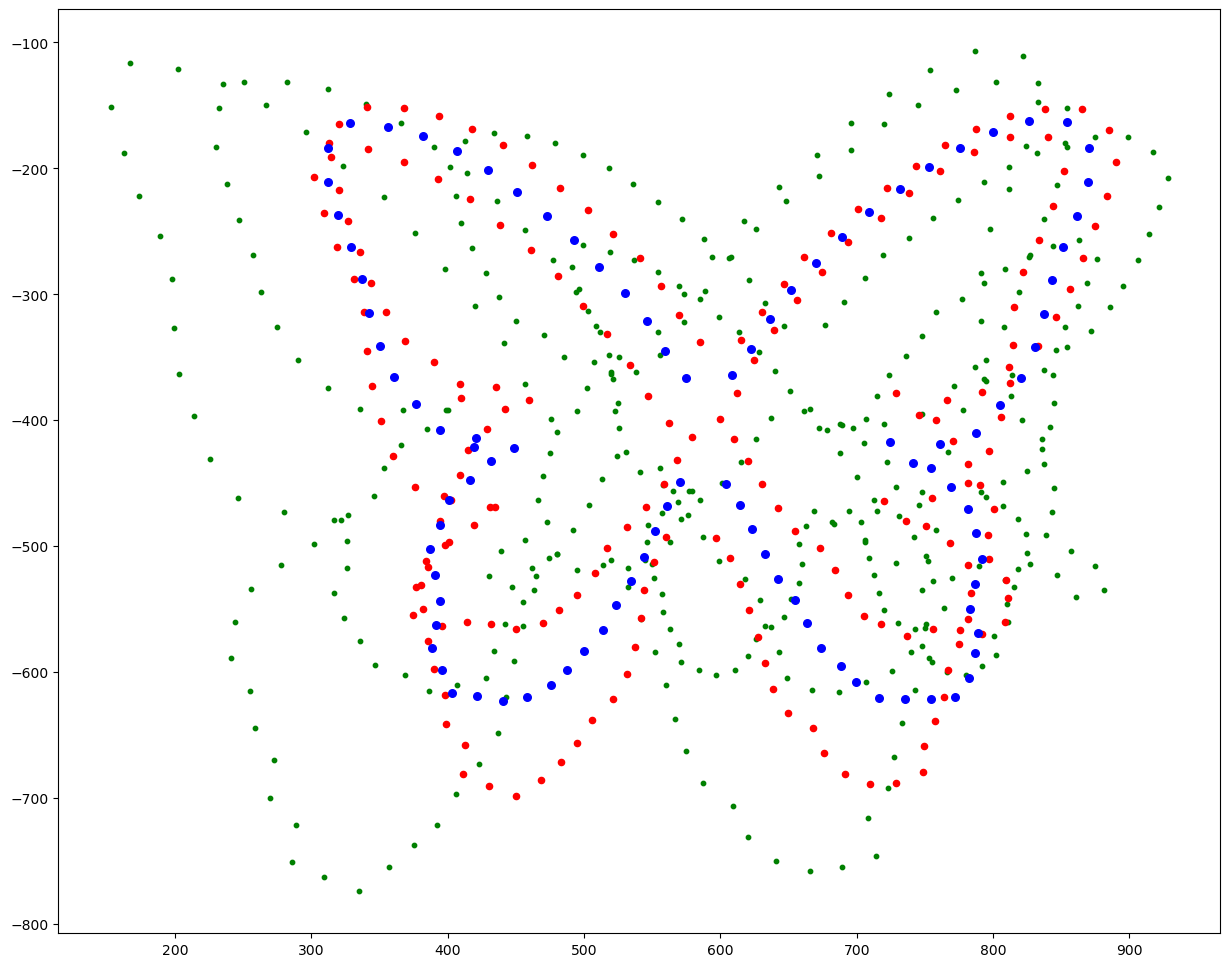

In [18]:
for i,data in enumerate(pre_tree.data['value'][pre_tree.is_leaf]):   
    plt.scatter(data[::2],-data[1::2],color="green",s=10)

for i,data in enumerate(pre_tree.data['value'][pre_tree.is_inner]):   
    plt.scatter(data[::2],-data[1::2],color="red",s=20)

plt.scatter(pre_tree.data['value'][0][::2], -pre_tree.data['value'][0][1::2], color='blue',s=30)    # root